1) sales_df_train.csv –данные по продажам за скользящий год для обучения.
st_id – захэшированное id магазина; 12 магазинов
pr_sku_id – захэшированное id товара; 1991
date – дата;
pr_sales_type_id – флаг наличия промо;
pr_sales_in_units – число проданных товаров без признака промо;
pr_promo_sales_in_units – число проданных товаров с признаком промо;
pr_sales_in_rub – продажи без признака промо в РУБ;
pr_promo_sales_in_rub – продажи с признаком промо в РУБ;

2) pr_df.csv – данные по товарной иерархии.
От большего к меньшему pr_group_id - pr_cat_id - pr_subcat_id - pr_sku_id.

pr_group_id – захэшированная группа товара; 9
pr_cat_id – захэшированная категория товара; 43
pr_subcat_id – захэшированная подкатегория товара; 167
pr_sku_id – захэшированное id товара; 1991
pr_uom_id (маркер, обозначающий продаётся товар на вес или в ШТ). - значения 1 и 17

3) pr_st.csv – данные по магазинам.

st_id – захэшированное id магазина; 12 магазинов
st_city_id – захэшированное id города; 7 городов
st_division_code id – захэшированное id дивизиона; 6 дивизионов
st_type_format_id – id формата магазина; 3
st_type_loc_id – id тип локации/окружения магазина; 3
st_type_size_id – id типа размера магазина; 6 типов
st_is_active – флаг активного магазина на данный момент. 2

# Прогнозирование спроса товаров собственного производства


### Описание задачи

Необходимо создать алгоритм прогноза спроса на 14 дней для товаров собственного производства. Гранулярность ТК-SKU-День.
 

### Описание данных

1. **sales_df_train.csv** –данные по продажам за скользящий год для обучения.

     * *st_id* – захэшированное id магазина;
     * *pr_sku_id* – захэшированное id товара;
     * *date* – дата;
     * *pr_sales_type_id* – флаг наличия промо;
     * *pr_sales_in_units* – число проданных товаров всего (промо и без);
     * *pr_promo_sales_in_units* – число проданных товаров с признаком промо;
     * *pr_sales_in_rub* – продажи с промо и без в РУБ;
     * *pr_promo_sales_in_rub* – продажи с признаком промо в РУБ;


2. **pr_df.csv** – данные по товарной иерархии.

    * *pr_group_id* – захэшированная группа товара;
    * *pr_cat_id* – захэшированная категория товара;
    * *pr_subcat_id* – захэшированная подкатегория товара;
    * *pr_sku_id* – захэшированное id товара;
    * *pr_uom_id* (маркер, обозначающий продаётся товар на вес или в ШТ).
    
    
    
3. **pr_st.csv** – данные по магазинам.

    * *st_id* – захэшированное id магазина;
    * *st_city_id* – захэшированное id города;
    * *st_division_code id* – захэшированное id дивизиона;
    * *st_type_format_id* – id формата магазина;
    * *st_type_loc_id* – id тип локации/окружения магазина;
    * *st_type_size_id* – id типа размера магазина;
    * *st_is_active* – флаг активного магазина на данный момент.



In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path
import seaborn as sns
import warnings
from scipy import stats
from datetime import timedelta

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from statsmodels.tsa.arima.model import ARIMA
from catboost import CatBoostRegressor

ModuleNotFoundError: No module named 'statsmodels'

ERROR: THESE PACKAGES DO NOT MATCH THE HASHES FROM THE REQUIREMENTS FILE. If you have updated the package versions, please update the hashes. Otherwise, examine the package contents carefully; someone may have tampered with them.
    numpy!=1.24.0,>=1.16.0 from https://files.pythonhosted.org/packages/b5/50/d7978137464251c393df28fe0592fbb968110f752d66f60c7a53f7158076/numpy-1.22.4-cp310-cp310-win_amd64.whl (from fedot):
        Expected sha256 3e1ffa4748168e1cc8d3cde93f006fe92b5421396221a02f2274aab6ac83b077
             Got        4a4ba48fbc2abd82abeb3bd929bacac968135b58bbd4e8f91cd9c9357723801b



  Obtaining dependency information for fedot from https://files.pythonhosted.org/packages/79/e7/c35bfa2241b3c385e7666b310bf91faac4845675bf27e8fd29590e7fbb8c/fedot-0.7.2-py3-none-any.whl.metadata
  Obtaining dependency information for thegolem==0.3.2 from https://files.pythonhosted.org/packages/f3/18/4d63667548691185816284178572ab2e072a9b80540091a403f6fcd22094/thegolem-0.3.2-py3-none-any.whl.metadata
  Obtaining dependency information for anytree>=2.8.0 from https://files.pythonhosted.org/packages/59/59/f14c7dcbe9b948414a221bb1be2593f42d6f201c0a9c690c5544c533c964/anytree-2.9.0-py3-none-any.whl.metadata
  Obtaining dependency information for lightgbm>=3.0.0 from https://files.pythonhosted.org/packages/b3/f8/ee33e36194eb03a76eccf3adac3fba51f0e56fbd20609bb531659d48d3cb/lightgbm-4.1.0-py3-none-win_amd64.whl.metadata
  Obtaining dependency information for xgboost>=1.4.0 from https://files.pythonhosted.org/packages/32/10/4689bda37403f7dd029d550c4446e0097c2f33b8ae877b235e76d5c49bc2/xgboost-2.0

In [2]:
# Открываем файлы
names = ['sales_df_train', 'pr_df', 'st_df']

for n in names:
    globals()[n] = pd.read_csv(f'{n}.csv')

In [3]:
temp_df = pd.merge(sales_df_train, pr_df, on='pr_sku_id')
df = pd.merge(temp_df, st_df, on='st_id')
del temp_df

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883015 entries, 0 to 883014
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   st_id                    883015 non-null  object 
 1   pr_sku_id                883015 non-null  object 
 2   date                     883015 non-null  object 
 3   pr_sales_type_id         883015 non-null  int64  
 4   pr_sales_in_units        883015 non-null  float64
 5   pr_promo_sales_in_units  883015 non-null  float64
 6   pr_sales_in_rub          883015 non-null  float64
 7   pr_promo_sales_in_rub    883015 non-null  float64
 8   pr_group_id              883015 non-null  object 
 9   pr_cat_id                883015 non-null  object 
 10  pr_subcat_id             883015 non-null  object 
 11  pr_uom_id                883015 non-null  int64  
 12  st_city_id               883015 non-null  object 
 13  st_division_code         883015 non-null  object 
 14  st_t

In [5]:
df.head()

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active
0,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-20,1,5.0,5.0,825.0,825.0,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1
1,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2023-02-02,1,1.0,1.0,107.0,107.0,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1
2,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-09,1,1.0,1.0,167.0,167.0,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1
3,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2023-06-22,0,0.0,0.0,79.0,0.0,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1
4,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2023-06-30,1,25.0,25.0,3766.0,3766.0,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1


In [6]:
df['date'] = pd.to_datetime(df['date']) 

In [7]:
# удалить все строки, где st_is_active == 0
df = df[df['st_is_active'] != 0]

# удалить столбец 'st_is_active' за ненадобностью
df = df.drop(columns=['st_is_active'])

# удалим столбцы с нулевыми продажами в штуках и ненулевой выручкой
df = df[~((df['pr_sales_in_units'] == 0) & (df['pr_sales_in_rub'] != 0))]

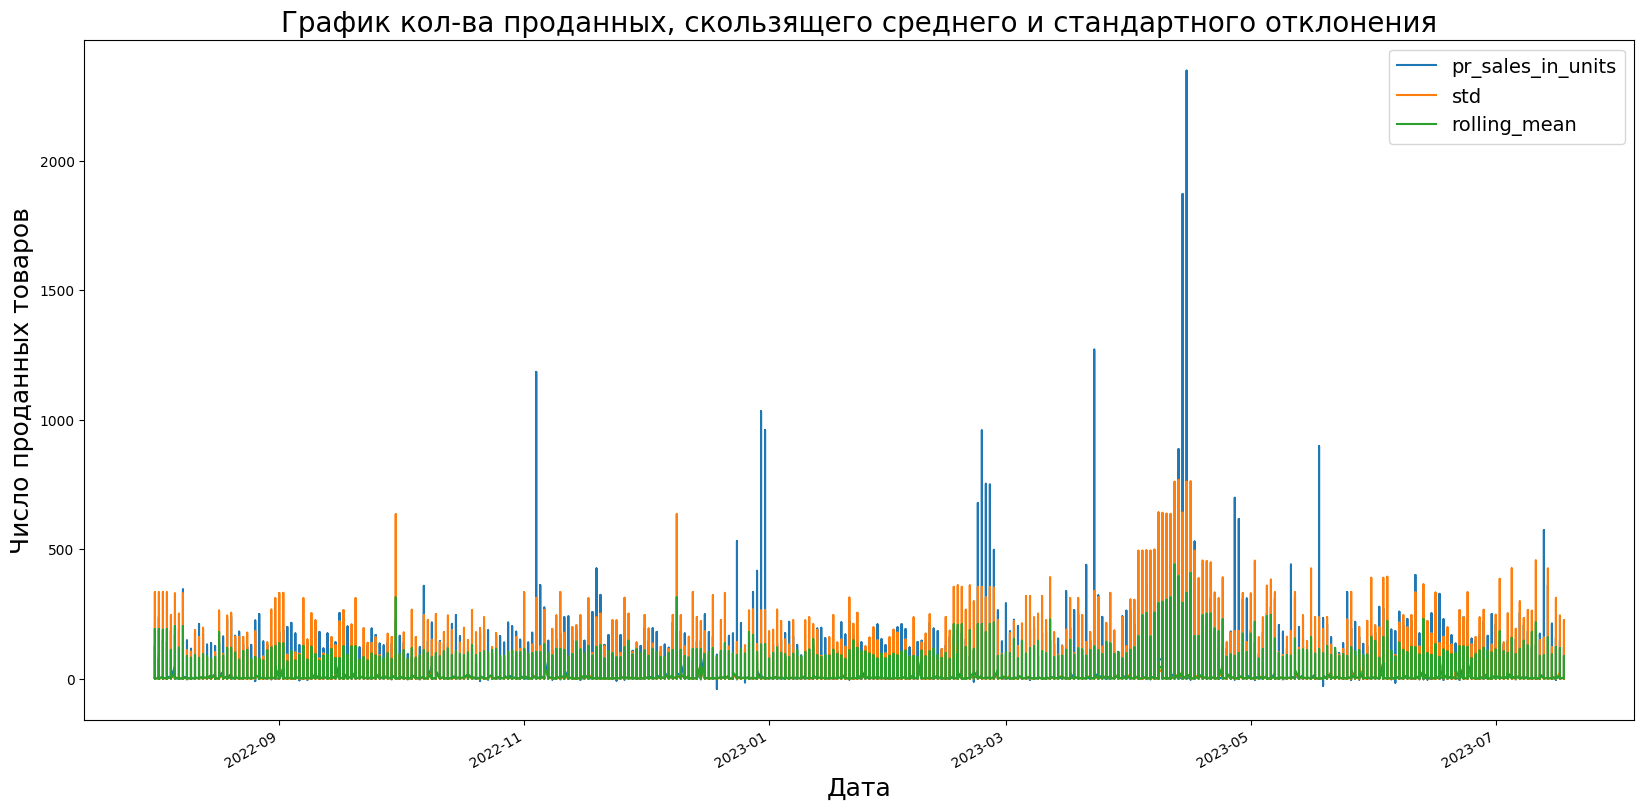

In [8]:
# Построим график кол-ва проданных, скользящего среднего и стандартного отклонения
df_plot = df.copy()

df_plot['rolling_mean'] = df_plot['pr_sales_in_units'].rolling(14).mean()
df_plot['std'] = df_plot['pr_sales_in_units'].rolling(14).std()

ax = df_plot[['date', 'pr_sales_in_units', 'std', 'rolling_mean']].plot(figsize=(20, 10), 
                                                                              x='date')

ax.set_title('График кол-ва проданных, скользящего среднего и стандартного отклонения', fontsize=20)
ax.set_xlabel('Дата', fontsize=18)
ax.set_ylabel('Число проданных товаров', fontsize=18)
ax.legend(fontsize=14)
plt.show()

In [9]:
# Создаем копию датафрейма
df_num = df.copy()

for column_name in df.columns:
    if df[column_name].dtype == 'object':  # Проверяем, является ли столбец хэшированным
        le = LabelEncoder()
        df_num[column_name] = le.fit_transform(df[column_name])
        
cat_cols = ['st_id', 'pr_sales_type_id', 'pr_group_id', 'pr_cat_id', 
            'pr_uom_id', 'st_city_id', 'st_division_code',
            'st_type_format_id', 'st_type_loc_id', 'st_type_size_id']

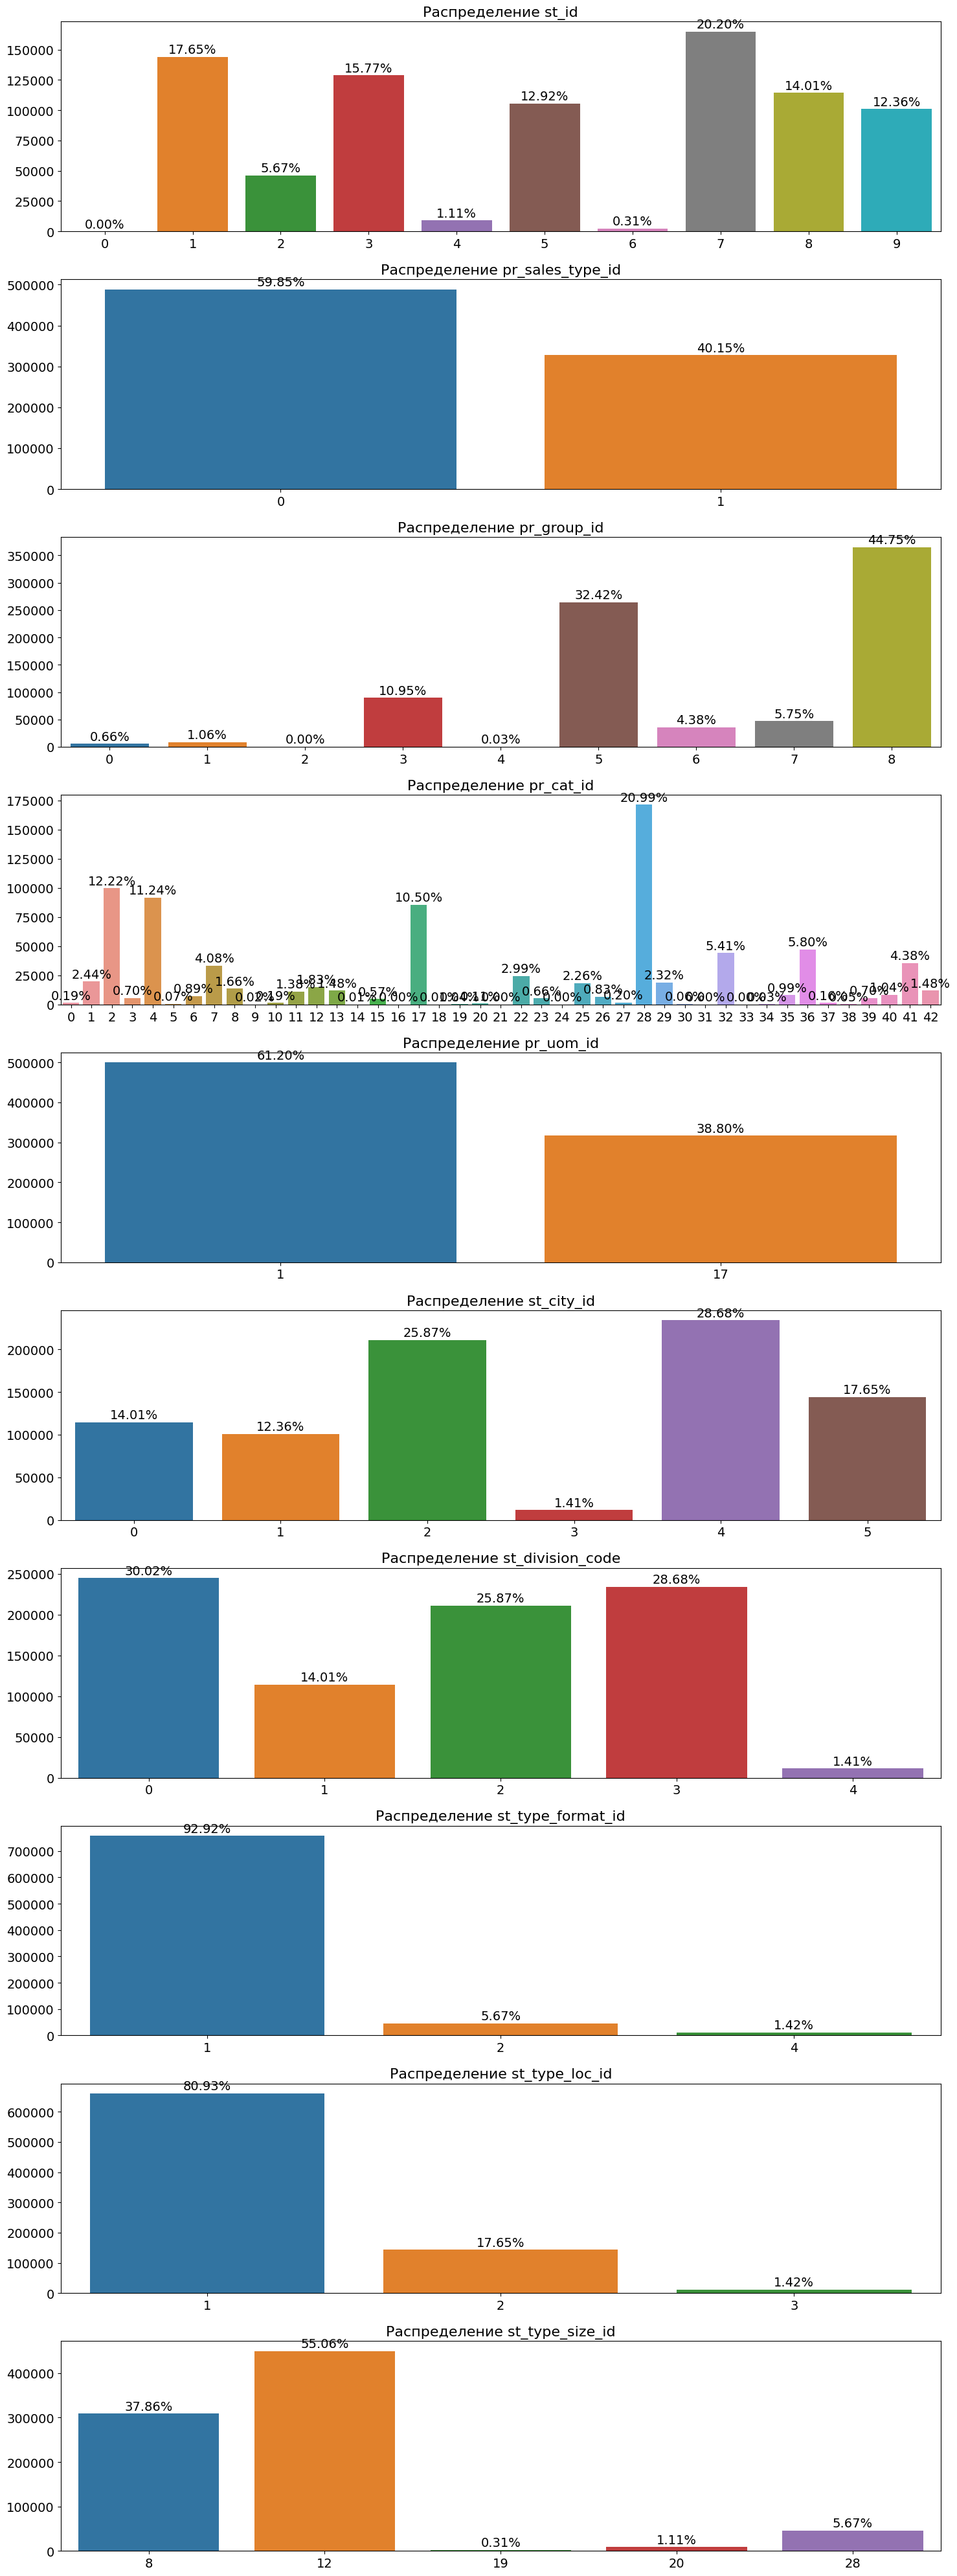

In [10]:
# Построение графиков распределения данных в категориальных признаках
plt.rc('font', size=14)
plt.rc('axes', titlesize=16) 
plt.rc('axes', labelsize=14)

cols = 1
rows = len(cat_cols)
fig = plt.figure(figsize= (15, 40), dpi=100)

for i, col in enumerate(cat_cols):
    ax=fig.add_subplot(rows, cols, i+1)
    sns.countplot(data=df_num, x=col, ax=ax)
    ax.set_title(f"Распределение {col}")
    ax.set(xlabel=None, ylabel=None)
    
    total = len(df_num)
    for p in ax.patches:
        percentage = f'{100 * p.get_height() / total:.2f}%\n'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='center')
    fig.tight_layout() 
plt.show()

In [11]:
def set_date_index(input_df, col_name='date'):
    modified_df = input_df.copy()
    modified_df[col_name] = pd.to_datetime(modified_df[col_name])
    modified_df.set_index(col_name, inplace=True)
    return modified_df  

def plot_cat_sales(data, name,  date, column1, column2, column3):
    df = data[data[column1] == name][[date, column2, column3]]
    df[date] = pd.to_datetime(df[date])
    df.set_index(date, inplace=True)
    pivot_table = df.pivot_table(index=df.index.month, columns=column2, values=column3, aggfunc='sum')

    plt.figure(figsize=(15, 5))
    sns.lineplot(data=pivot_table)
    plt.legend(loc='upper left')
    plt.xlabel('Месяц')
    plt.ylabel('Количество товара')
    plt.title(f'Изменение продаж товаров {name} группы по категориям по месяцам')
    plt.show()

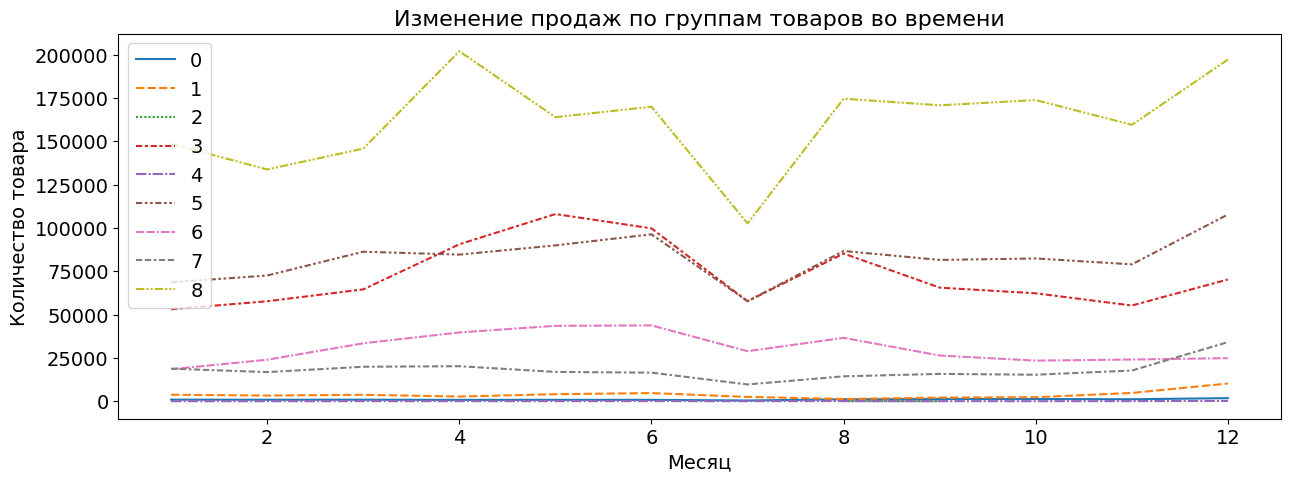

In [12]:
#  Визуализация распределения общих продаж каждой группы товаров во времени
df_plot = df_num[['date', 'pr_group_id', 'pr_sales_in_units']].copy()
df_plot = set_date_index(df_plot, 'date')
pivot_table = df_plot.pivot_table(index=df_plot.index.month, columns='pr_group_id', values='pr_sales_in_units', aggfunc='sum')

plt.figure(figsize=(15, 5))
sns.lineplot(data=pivot_table)

plt.legend(loc='upper left')
plt.xlabel('Месяц')
plt.ylabel('Количество товара')
plt.title('Изменение продаж по группам товаров во времени')

plt.show()

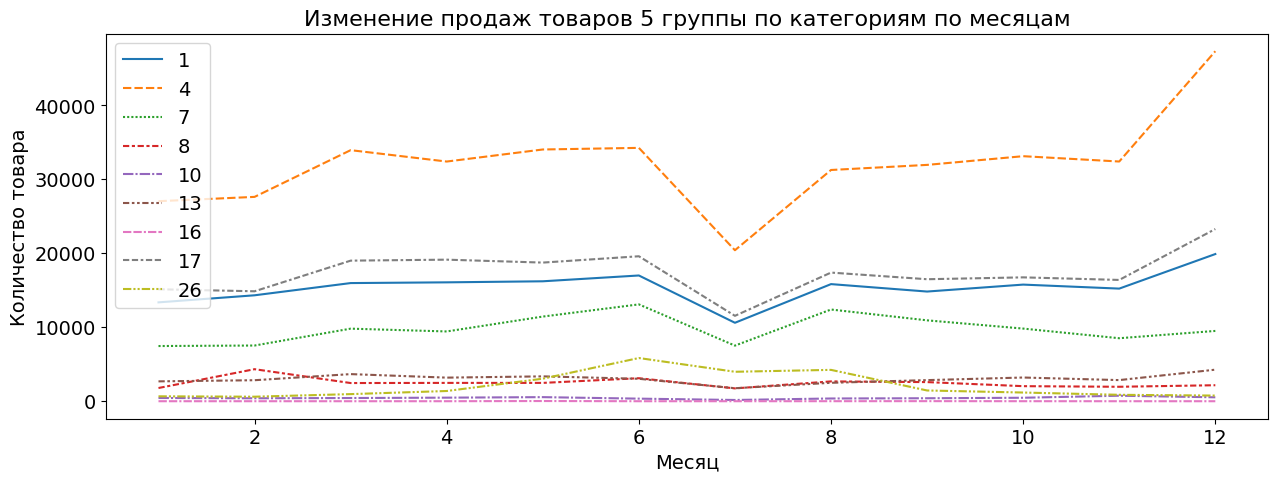

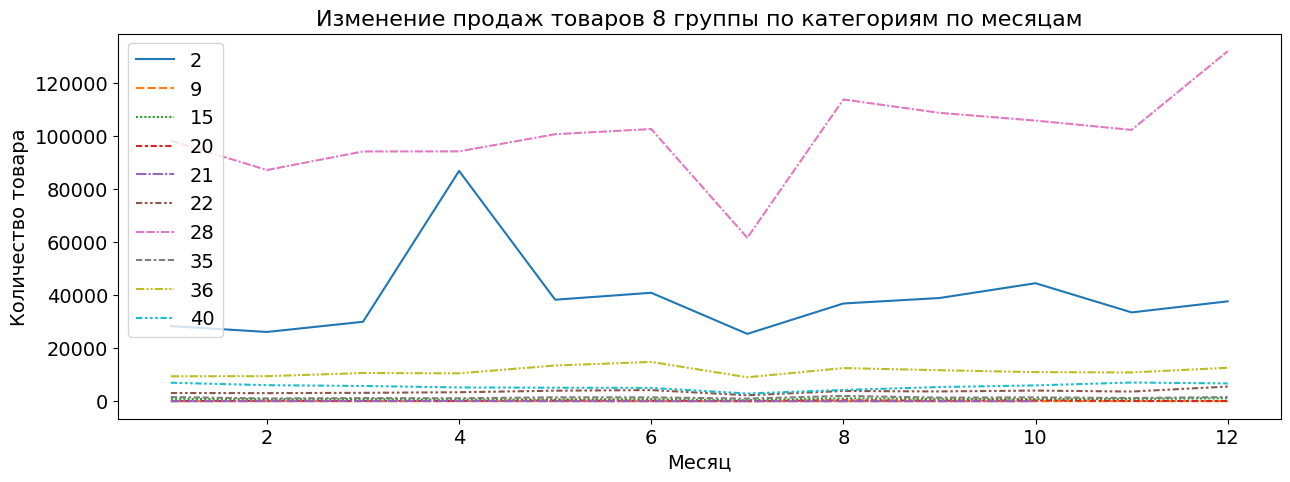

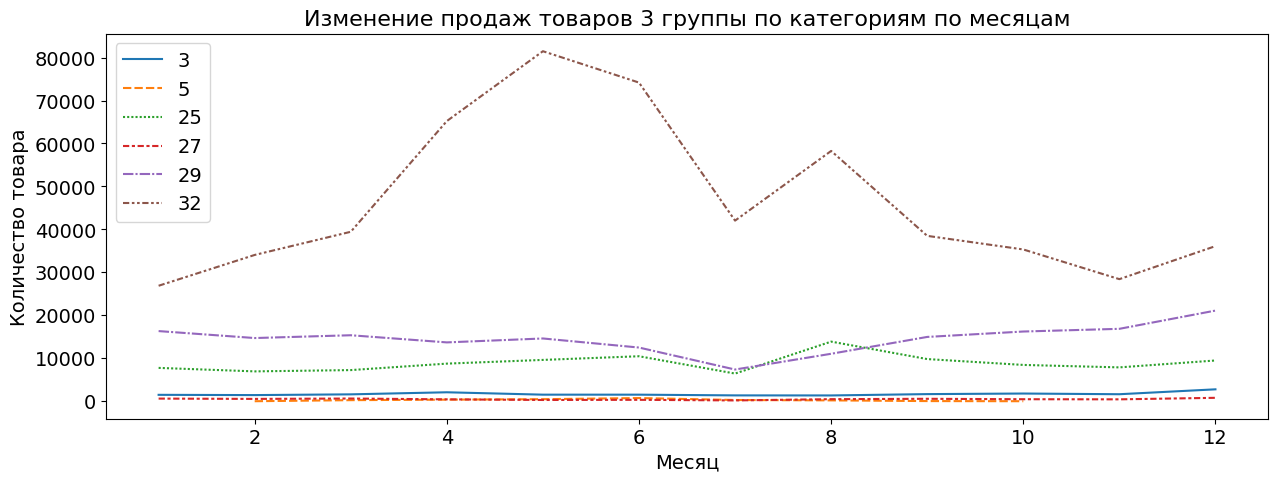

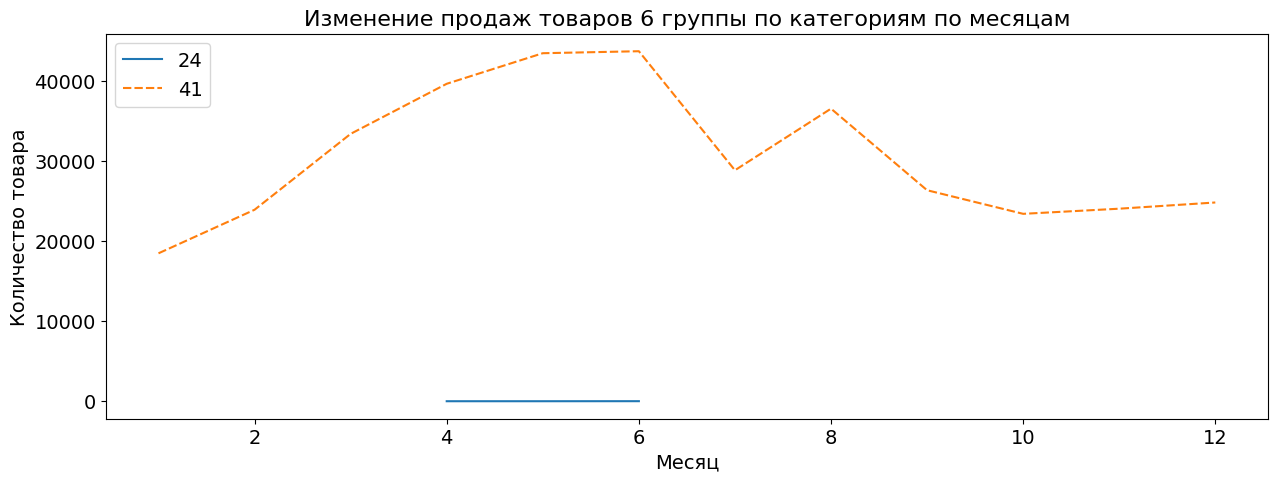

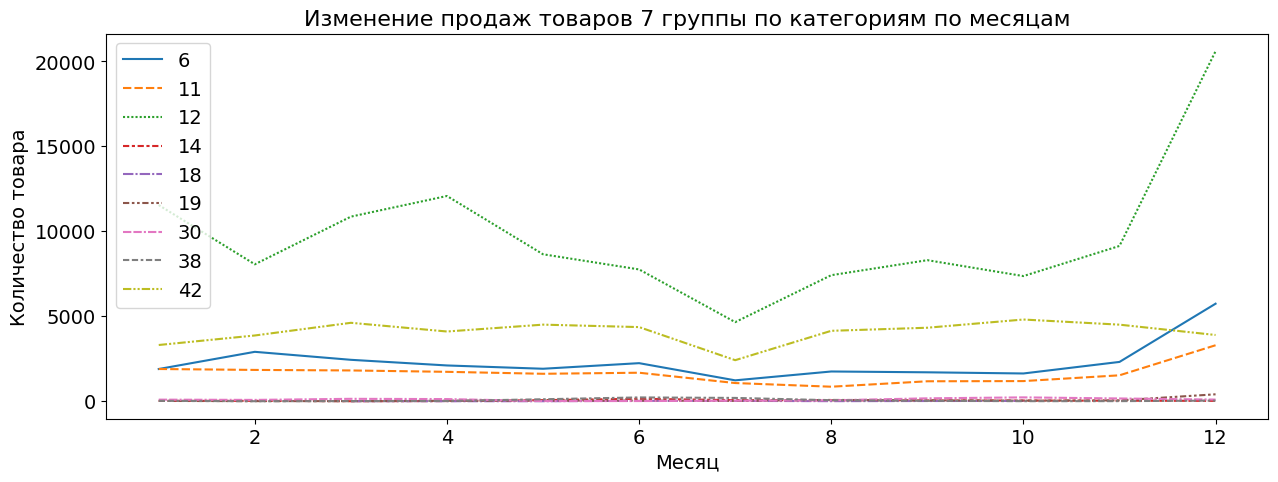

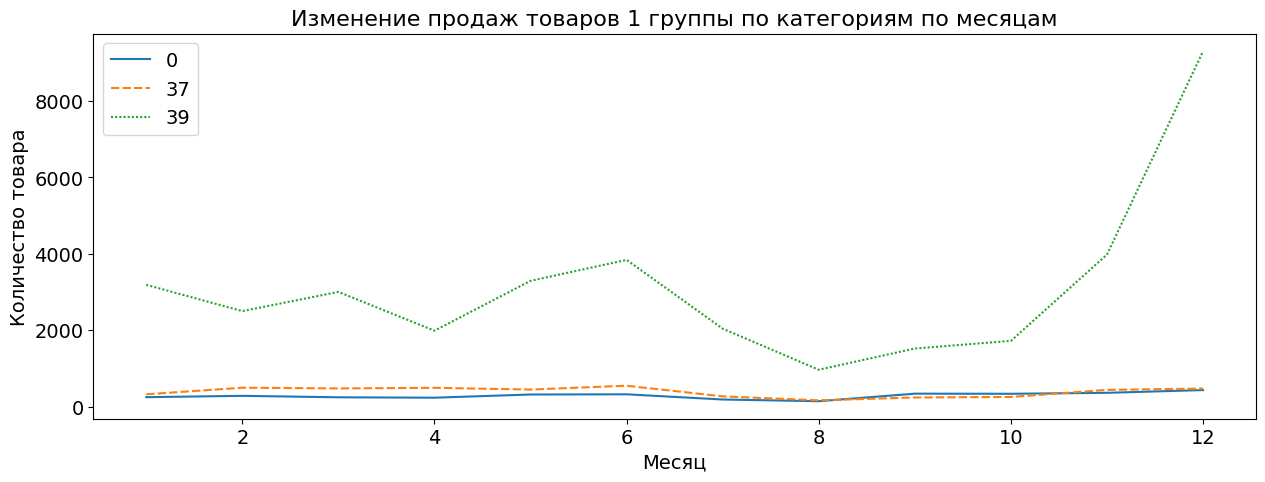

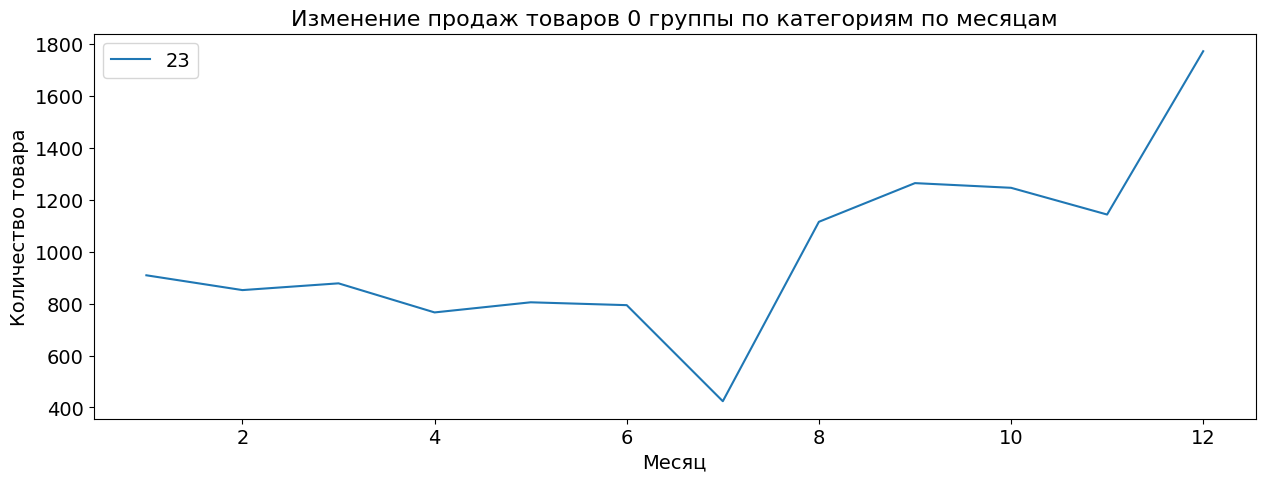

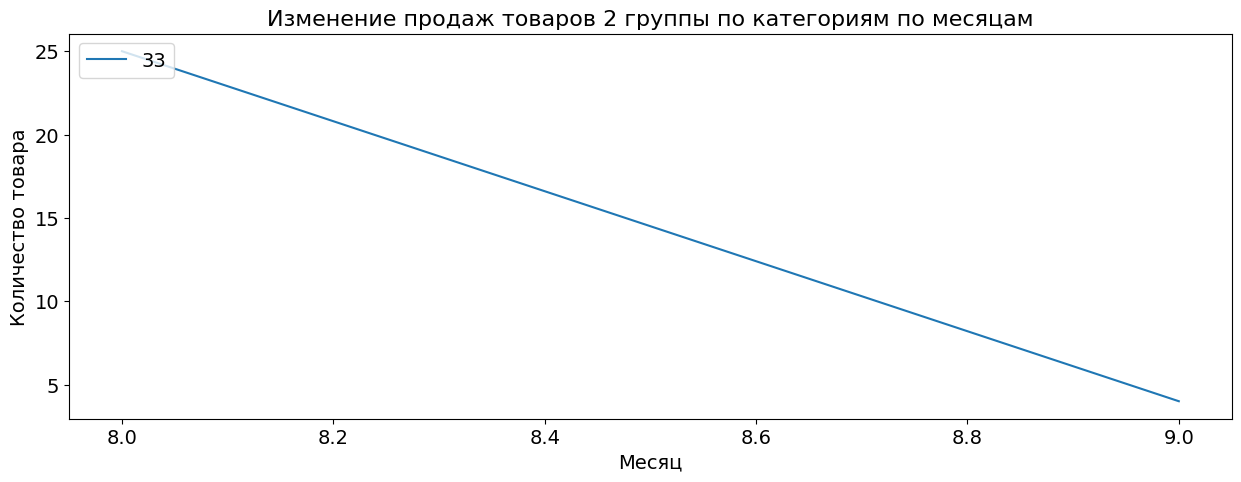

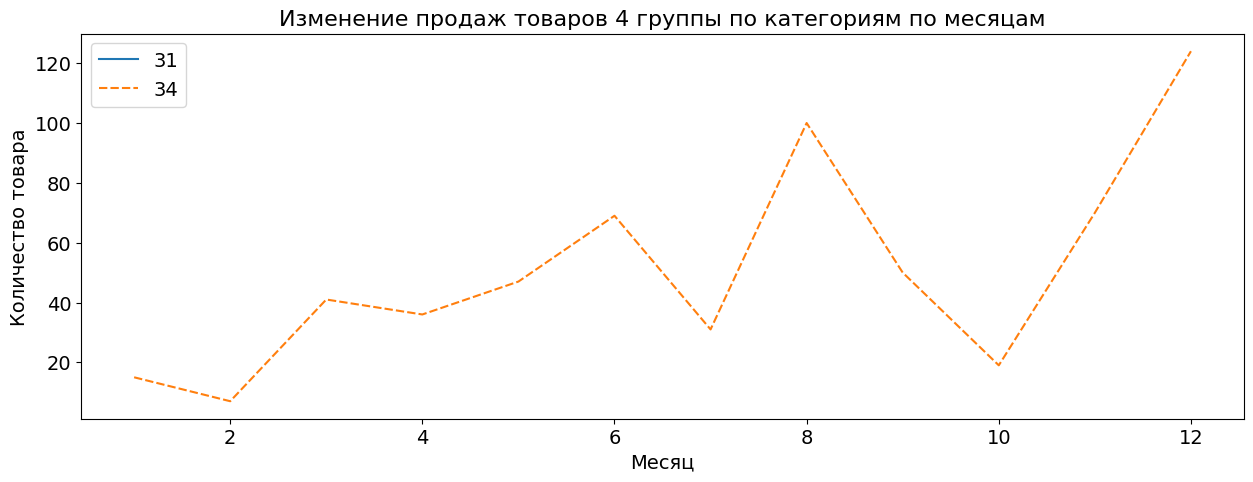

In [13]:
# Визуализация продаж категорий товаров внутри групп во времени
name_group_id = df_num['pr_group_id'].unique()

for name in name_group_id:
    plot_cat_sales(df_num, name,  'date', 'pr_group_id', 'pr_cat_id', 'pr_sales_in_units')

## Prophet

In [15]:
data = df.copy()
# Предобработка данных
data['pr_sales_in_units'] = data['pr_sales_in_units'].apply(lambda x: max(0, x))

# Генерация новых признаков
for window in [3, 7, 14]:
    data[f'rolling_mean_{window}'] = data['pr_sales_in_units'].rolling(window).mean()

# Построение моделей
prophet_model = Prophet()
arima_model = ARIMA(data['pr_sales_in_units'], order=(5,1,0))
catboost_model = CatBoostRegressor()

# Обучение моделей
prophet_model.fit(data[['date', 'pr_sales_in_units']])
arima_model.fit()
catboost_model.fit(data.drop('pr_sales_in_units', axis=1), data['pr_sales_in_units'])

# Предсказание
prophet_pred = prophet_model.predict(future)
arima_pred = arima_model.predict(start=len(data), end=len(data)+14)
data['prophet_pred'] = prophet_pred
data['arima_pred'] = arima_pred

catboost_pred = catboost_model.predict(data.drop('pr_sales_in_units', axis=1))

10:15:40 - cmdstanpy - INFO - Chain [1] start processing
10:15:40 - cmdstanpy - INFO - Chain [1] done processing
10:15:41 - cmdstanpy - INFO - Chain [1] start processing
10:15:41 - cmdstanpy - INFO - Chain [1] done processing
10:15:41 - cmdstanpy - INFO - Chain [1] start processing
10:15:41 - cmdstanpy - INFO - Chain [1] done processing
10:15:41 - cmdstanpy - INFO - Chain [1] start processing
10:15:42 - cmdstanpy - INFO - Chain [1] done processing
10:15:42 - cmdstanpy - INFO - Chain [1] start processing
10:15:42 - cmdstanpy - INFO - Chain [1] done processing
10:15:42 - cmdstanpy - INFO - Chain [1] start processing
10:15:42 - cmdstanpy - INFO - Chain [1] done processing
10:15:43 - cmdstanpy - INFO - Chain [1] start processing
10:15:43 - cmdstanpy - INFO - Chain [1] done processing
10:15:43 - cmdstanpy - INFO - Chain [1] start processing
10:15:43 - cmdstanpy - INFO - Chain [1] done processing
10:15:43 - cmdstanpy - INFO - Chain [1] start processing
10:15:43 - cmdstanpy - INFO - Chain [1]

10:16:08 - cmdstanpy - INFO - Chain [1] done processing
10:16:08 - cmdstanpy - INFO - Chain [1] start processing
10:16:08 - cmdstanpy - INFO - Chain [1] done processing
10:16:09 - cmdstanpy - INFO - Chain [1] start processing
10:16:09 - cmdstanpy - INFO - Chain [1] done processing
10:16:09 - cmdstanpy - INFO - Chain [1] start processing
10:16:09 - cmdstanpy - INFO - Chain [1] done processing
10:16:09 - cmdstanpy - INFO - Chain [1] start processing
10:16:09 - cmdstanpy - INFO - Chain [1] done processing
10:16:10 - cmdstanpy - INFO - Chain [1] start processing
10:16:10 - cmdstanpy - INFO - Chain [1] done processing
10:16:10 - cmdstanpy - INFO - Chain [1] start processing
10:16:10 - cmdstanpy - INFO - Chain [1] done processing
10:16:10 - cmdstanpy - INFO - Chain [1] start processing
10:16:10 - cmdstanpy - INFO - Chain [1] done processing
10:16:11 - cmdstanpy - INFO - Chain [1] start processing
10:16:12 - cmdstanpy - INFO - Chain [1] done processing
10:16:12 - cmdstanpy - INFO - Chain [1] 

10:16:37 - cmdstanpy - INFO - Chain [1] done processing
10:16:37 - cmdstanpy - INFO - Chain [1] start processing
10:16:37 - cmdstanpy - INFO - Chain [1] done processing
10:16:37 - cmdstanpy - INFO - Chain [1] start processing
10:16:37 - cmdstanpy - INFO - Chain [1] done processing
10:16:38 - cmdstanpy - INFO - Chain [1] start processing
10:16:38 - cmdstanpy - INFO - Chain [1] done processing
10:16:38 - cmdstanpy - INFO - Chain [1] start processing
10:16:38 - cmdstanpy - INFO - Chain [1] done processing
10:16:38 - cmdstanpy - INFO - Chain [1] start processing
10:16:39 - cmdstanpy - INFO - Chain [1] done processing
10:16:39 - cmdstanpy - INFO - Chain [1] start processing
10:16:39 - cmdstanpy - INFO - Chain [1] done processing
10:16:39 - cmdstanpy - INFO - Chain [1] start processing
10:16:39 - cmdstanpy - INFO - Chain [1] done processing
10:16:40 - cmdstanpy - INFO - Chain [1] start processing
10:16:40 - cmdstanpy - INFO - Chain [1] done processing
10:16:40 - cmdstanpy - INFO - Chain [1] 

10:17:04 - cmdstanpy - INFO - Chain [1] done processing
10:17:05 - cmdstanpy - INFO - Chain [1] start processing
10:17:05 - cmdstanpy - INFO - Chain [1] done processing
10:17:05 - cmdstanpy - INFO - Chain [1] start processing
10:17:05 - cmdstanpy - INFO - Chain [1] done processing
10:17:05 - cmdstanpy - INFO - Chain [1] start processing
10:17:05 - cmdstanpy - INFO - Chain [1] done processing
10:17:06 - cmdstanpy - INFO - Chain [1] start processing
10:17:06 - cmdstanpy - INFO - Chain [1] done processing
10:17:06 - cmdstanpy - INFO - Chain [1] start processing
10:17:06 - cmdstanpy - INFO - Chain [1] done processing
10:17:06 - cmdstanpy - INFO - Chain [1] start processing
10:17:07 - cmdstanpy - INFO - Chain [1] done processing
10:17:07 - cmdstanpy - INFO - Chain [1] start processing
10:17:07 - cmdstanpy - INFO - Chain [1] done processing
10:17:07 - cmdstanpy - INFO - Chain [1] start processing
10:17:07 - cmdstanpy - INFO - Chain [1] done processing
10:17:08 - cmdstanpy - INFO - Chain [1] 

10:17:32 - cmdstanpy - INFO - Chain [1] done processing
10:17:32 - cmdstanpy - INFO - Chain [1] start processing
10:17:32 - cmdstanpy - INFO - Chain [1] done processing
10:17:33 - cmdstanpy - INFO - Chain [1] start processing
10:17:33 - cmdstanpy - INFO - Chain [1] done processing
10:17:33 - cmdstanpy - INFO - Chain [1] start processing
10:17:33 - cmdstanpy - INFO - Chain [1] done processing
10:17:34 - cmdstanpy - INFO - Chain [1] start processing
10:17:34 - cmdstanpy - INFO - Chain [1] done processing
10:17:34 - cmdstanpy - INFO - Chain [1] start processing
10:17:34 - cmdstanpy - INFO - Chain [1] done processing
10:17:34 - cmdstanpy - INFO - Chain [1] start processing
10:17:34 - cmdstanpy - INFO - Chain [1] done processing
10:17:35 - cmdstanpy - INFO - Chain [1] start processing
10:17:35 - cmdstanpy - INFO - Chain [1] done processing
10:17:35 - cmdstanpy - INFO - Chain [1] start processing
10:17:35 - cmdstanpy - INFO - Chain [1] done processing
10:17:35 - cmdstanpy - INFO - Chain [1] 

10:18:00 - cmdstanpy - INFO - Chain [1] done processing
10:18:00 - cmdstanpy - INFO - Chain [1] start processing
10:18:00 - cmdstanpy - INFO - Chain [1] done processing
10:18:01 - cmdstanpy - INFO - Chain [1] start processing
10:18:01 - cmdstanpy - INFO - Chain [1] done processing
10:18:01 - cmdstanpy - INFO - Chain [1] start processing
10:18:01 - cmdstanpy - INFO - Chain [1] done processing
10:18:01 - cmdstanpy - INFO - Chain [1] start processing
10:18:02 - cmdstanpy - INFO - Chain [1] done processing
10:18:02 - cmdstanpy - INFO - Chain [1] start processing
10:18:02 - cmdstanpy - INFO - Chain [1] done processing
10:18:02 - cmdstanpy - INFO - Chain [1] start processing
10:18:02 - cmdstanpy - INFO - Chain [1] done processing
10:18:03 - cmdstanpy - INFO - Chain [1] start processing
10:18:03 - cmdstanpy - INFO - Chain [1] done processing
10:18:03 - cmdstanpy - INFO - Chain [1] start processing
10:18:03 - cmdstanpy - INFO - Chain [1] done processing
10:18:03 - cmdstanpy - INFO - Chain [1] 

10:18:27 - cmdstanpy - INFO - Chain [1] done processing
10:18:28 - cmdstanpy - INFO - Chain [1] start processing
10:18:28 - cmdstanpy - INFO - Chain [1] done processing
10:18:28 - cmdstanpy - INFO - Chain [1] start processing
10:18:28 - cmdstanpy - INFO - Chain [1] done processing
10:18:29 - cmdstanpy - INFO - Chain [1] start processing
10:18:29 - cmdstanpy - INFO - Chain [1] done processing
10:18:29 - cmdstanpy - INFO - Chain [1] start processing
10:18:29 - cmdstanpy - INFO - Chain [1] done processing
10:18:29 - cmdstanpy - INFO - Chain [1] start processing
10:18:29 - cmdstanpy - INFO - Chain [1] done processing
10:18:30 - cmdstanpy - INFO - Chain [1] start processing
10:18:30 - cmdstanpy - INFO - Chain [1] done processing
10:18:30 - cmdstanpy - INFO - Chain [1] start processing
10:18:30 - cmdstanpy - INFO - Chain [1] done processing
10:18:31 - cmdstanpy - INFO - Chain [1] start processing
10:18:31 - cmdstanpy - INFO - Chain [1] done processing
10:18:31 - cmdstanpy - INFO - Chain [1] 

10:18:55 - cmdstanpy - INFO - Chain [1] done processing
10:18:56 - cmdstanpy - INFO - Chain [1] start processing
10:18:56 - cmdstanpy - INFO - Chain [1] done processing
10:18:56 - cmdstanpy - INFO - Chain [1] start processing
10:18:56 - cmdstanpy - INFO - Chain [1] done processing
10:18:56 - cmdstanpy - INFO - Chain [1] start processing
10:18:56 - cmdstanpy - INFO - Chain [1] done processing
10:18:57 - cmdstanpy - INFO - Chain [1] start processing
10:18:57 - cmdstanpy - INFO - Chain [1] done processing
10:18:57 - cmdstanpy - INFO - Chain [1] start processing
10:18:57 - cmdstanpy - INFO - Chain [1] done processing
10:18:57 - cmdstanpy - INFO - Chain [1] start processing
10:18:58 - cmdstanpy - INFO - Chain [1] done processing
10:18:58 - cmdstanpy - INFO - Chain [1] start processing
10:18:58 - cmdstanpy - INFO - Chain [1] done processing
10:18:58 - cmdstanpy - INFO - Chain [1] start processing
10:18:58 - cmdstanpy - INFO - Chain [1] done processing
10:18:59 - cmdstanpy - INFO - Chain [1] 

10:19:24 - cmdstanpy - INFO - Chain [1] done processing
10:19:24 - cmdstanpy - INFO - Chain [1] start processing
10:19:24 - cmdstanpy - INFO - Chain [1] done processing
10:19:25 - cmdstanpy - INFO - Chain [1] start processing
10:19:25 - cmdstanpy - INFO - Chain [1] done processing
10:19:25 - cmdstanpy - INFO - Chain [1] start processing
10:19:25 - cmdstanpy - INFO - Chain [1] done processing
10:19:25 - cmdstanpy - INFO - Chain [1] start processing
10:19:25 - cmdstanpy - INFO - Chain [1] done processing
10:19:26 - cmdstanpy - INFO - Chain [1] start processing
10:19:26 - cmdstanpy - INFO - Chain [1] done processing
10:19:26 - cmdstanpy - INFO - Chain [1] start processing
10:19:26 - cmdstanpy - INFO - Chain [1] done processing
10:19:27 - cmdstanpy - INFO - Chain [1] start processing
10:19:27 - cmdstanpy - INFO - Chain [1] done processing
10:19:27 - cmdstanpy - INFO - Chain [1] start processing
10:19:27 - cmdstanpy - INFO - Chain [1] done processing
10:19:28 - cmdstanpy - INFO - Chain [1] 

10:19:54 - cmdstanpy - INFO - Chain [1] done processing
10:19:55 - cmdstanpy - INFO - Chain [1] start processing
10:19:55 - cmdstanpy - INFO - Chain [1] done processing
10:19:55 - cmdstanpy - INFO - Chain [1] start processing
10:19:55 - cmdstanpy - INFO - Chain [1] done processing
10:19:56 - cmdstanpy - INFO - Chain [1] start processing
10:19:56 - cmdstanpy - INFO - Chain [1] done processing
10:19:56 - cmdstanpy - INFO - Chain [1] start processing
10:19:56 - cmdstanpy - INFO - Chain [1] done processing
10:19:56 - cmdstanpy - INFO - Chain [1] start processing
10:19:56 - cmdstanpy - INFO - Chain [1] done processing
10:19:57 - cmdstanpy - INFO - Chain [1] start processing
10:19:57 - cmdstanpy - INFO - Chain [1] done processing
10:19:57 - cmdstanpy - INFO - Chain [1] start processing
10:19:57 - cmdstanpy - INFO - Chain [1] done processing
10:19:58 - cmdstanpy - INFO - Chain [1] start processing
10:19:58 - cmdstanpy - INFO - Chain [1] done processing
10:19:58 - cmdstanpy - INFO - Chain [1] 

10:20:24 - cmdstanpy - INFO - Chain [1] done processing
10:20:24 - cmdstanpy - INFO - Chain [1] start processing
10:20:24 - cmdstanpy - INFO - Chain [1] done processing
10:20:25 - cmdstanpy - INFO - Chain [1] start processing
10:20:25 - cmdstanpy - INFO - Chain [1] done processing
10:20:25 - cmdstanpy - INFO - Chain [1] start processing
10:20:25 - cmdstanpy - INFO - Chain [1] done processing
10:20:26 - cmdstanpy - INFO - Chain [1] start processing
10:20:26 - cmdstanpy - INFO - Chain [1] done processing
10:20:26 - cmdstanpy - INFO - Chain [1] start processing
10:20:26 - cmdstanpy - INFO - Chain [1] done processing
10:20:27 - cmdstanpy - INFO - Chain [1] start processing
10:20:27 - cmdstanpy - INFO - Chain [1] done processing
10:20:27 - cmdstanpy - INFO - Chain [1] start processing
10:20:27 - cmdstanpy - INFO - Chain [1] done processing
10:20:27 - cmdstanpy - INFO - Chain [1] start processing
10:20:27 - cmdstanpy - INFO - Chain [1] done processing
10:20:28 - cmdstanpy - INFO - Chain [1] 

10:20:54 - cmdstanpy - INFO - Chain [1] done processing
10:20:54 - cmdstanpy - INFO - Chain [1] start processing
10:20:54 - cmdstanpy - INFO - Chain [1] done processing
10:20:55 - cmdstanpy - INFO - Chain [1] start processing
10:20:55 - cmdstanpy - INFO - Chain [1] done processing
10:20:55 - cmdstanpy - INFO - Chain [1] start processing
10:20:55 - cmdstanpy - INFO - Chain [1] done processing
10:20:56 - cmdstanpy - INFO - Chain [1] start processing
10:20:56 - cmdstanpy - INFO - Chain [1] done processing
10:20:56 - cmdstanpy - INFO - Chain [1] start processing
10:20:56 - cmdstanpy - INFO - Chain [1] done processing
10:20:57 - cmdstanpy - INFO - Chain [1] start processing
10:20:57 - cmdstanpy - INFO - Chain [1] done processing
10:20:57 - cmdstanpy - INFO - Chain [1] start processing
10:20:57 - cmdstanpy - INFO - Chain [1] done processing
10:20:58 - cmdstanpy - INFO - Chain [1] start processing
10:20:58 - cmdstanpy - INFO - Chain [1] done processing
10:20:58 - cmdstanpy - INFO - Chain [1] 

10:21:27 - cmdstanpy - INFO - Chain [1] done processing
10:21:28 - cmdstanpy - INFO - Chain [1] start processing
10:21:28 - cmdstanpy - INFO - Chain [1] done processing
10:21:28 - cmdstanpy - INFO - Chain [1] start processing
10:21:28 - cmdstanpy - INFO - Chain [1] done processing
10:21:29 - cmdstanpy - INFO - Chain [1] start processing
10:21:29 - cmdstanpy - INFO - Chain [1] done processing
10:21:29 - cmdstanpy - INFO - Chain [1] start processing
10:21:29 - cmdstanpy - INFO - Chain [1] done processing
10:21:29 - cmdstanpy - INFO - Chain [1] start processing
10:21:29 - cmdstanpy - INFO - Chain [1] done processing
10:21:30 - cmdstanpy - INFO - Chain [1] start processing
10:21:30 - cmdstanpy - INFO - Chain [1] done processing
10:21:30 - cmdstanpy - INFO - Chain [1] start processing
10:21:30 - cmdstanpy - INFO - Chain [1] done processing
10:21:30 - cmdstanpy - INFO - Chain [1] start processing
10:21:30 - cmdstanpy - INFO - Chain [1] done processing
10:21:31 - cmdstanpy - INFO - Chain [1] 

KeyboardInterrupt: 

In [18]:
len(df['pr_subcat_id'].unique())

165

In [22]:
data = df.copy()

# Предобработка данных
data['pr_sales_in_units'] = data['pr_sales_in_units'].apply(lambda x: max(0, x))

# Создание и обучение модели Prophet для каждого уникального сочетания st_id и pr_sku_id
grouped = data.groupby(['st_id', 'pr_sku_id'])
grouped.head()

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id
0,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-20,1,5.0,5.0,825.0,825.0,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8
1,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2023-02-02,1,1.0,1.0,107.0,107.0,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8
2,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-09,1,1.0,1.0,167.0,167.0,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8
4,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2023-06-30,1,25.0,25.0,3766.0,3766.0,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8
5,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-12-29,0,49.0,0.0,9143.0,0.0,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
882996,084a8a9aa8cced9175bd07bc44998e75,c2718cfd2edcbadfe0162a4f4c91f3a0,2023-03-26,1,2.0,2.0,254.0,254.0,c74d97b01eae257e44aa9d5bade97baf,a368b0de8b91cfb3f91892fbf1ebd4b2,8feef08314d477a5b68ba18a6d35819d,17,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,4,3,19
882997,084a8a9aa8cced9175bd07bc44998e75,c2718cfd2edcbadfe0162a4f4c91f3a0,2023-03-30,1,2.0,2.0,250.0,250.0,c74d97b01eae257e44aa9d5bade97baf,a368b0de8b91cfb3f91892fbf1ebd4b2,8feef08314d477a5b68ba18a6d35819d,17,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,4,3,19
883002,084a8a9aa8cced9175bd07bc44998e75,be8d2843456cac871fc116ab25d02994,2023-06-11,0,1.0,0.0,210.0,0.0,c74d97b01eae257e44aa9d5bade97baf,a368b0de8b91cfb3f91892fbf1ebd4b2,8feef08314d477a5b68ba18a6d35819d,17,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,4,3,19
883003,084a8a9aa8cced9175bd07bc44998e75,be8d2843456cac871fc116ab25d02994,2023-04-26,0,1.0,0.0,210.0,0.0,c74d97b01eae257e44aa9d5bade97baf,a368b0de8b91cfb3f91892fbf1ebd4b2,8feef08314d477a5b68ba18a6d35819d,17,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,4,3,19


In [23]:
data = df.copy()

# Предобработка данных
data['pr_sales_in_units'] = data['pr_sales_in_units'].apply(lambda x: max(0, x))

# Группировка данных по pr_group_id и дате, и подсчет суммы pr_sales_in_units для каждой группы
grouped_data = data.groupby(['pr_group_id', 'date'])['pr_sales_in_units'].sum().reset_index()

# Создание и обучение модели Prophet для каждого уникального pr_group_id
grouped = grouped_data.groupby('pr_group_id')
prophet_pred = pd.DataFrame()
for name, group in grouped:
    model = Prophet(yearly_seasonality=True, daily_seasonality=True)
    try:
        model.fit(group[['date', 'pr_sales_in_units']].rename(columns={'date': 'ds', 'pr_sales_in_units': 'y'}))
        
        # Создание DataFrame для будущих дат
        future = model.make_future_dataframe(periods=14)
        
        # Предсказание
        forecast = model.predict(future)
        
        # Добавление предсказаний в prophet_pred
        forecast['pr_group_id'] = name
        prophet_pred = pd.concat([prophet_pred, forecast], ignore_index=True)
    except:
        # Если возникнет ошибка или невозможность предсказать, установите предсказание равным 0
        future = pd.DataFrame({'ds': pd.date_range(start=group['date'].max(), periods=15)})
        future['yhat'] = 0
        future['pr_group_id'] = name
        prophet_pred = pd.concat([prophet_pred, future], ignore_index=True)

# Если возникнет ошибка или невозможность предсказать, замените предсказания на 0
prophet_pred['yhat'] = prophet_pred['yhat'].apply(lambda x: max(0, x))

12:23:04 - cmdstanpy - INFO - Chain [1] start processing
12:23:04 - cmdstanpy - INFO - Chain [1] done processing
12:23:05 - cmdstanpy - INFO - Chain [1] start processing
12:23:05 - cmdstanpy - INFO - Chain [1] done processing
12:23:05 - cmdstanpy - INFO - Chain [1] start processing
12:23:05 - cmdstanpy - INFO - Chain [1] done processing
12:23:05 - cmdstanpy - INFO - Chain [1] start processing
12:23:05 - cmdstanpy - INFO - Chain [1] done processing
12:23:05 - cmdstanpy - INFO - Chain [1] start processing
12:23:05 - cmdstanpy - INFO - Chain [1] done processing
12:23:06 - cmdstanpy - INFO - Chain [1] start processing
12:23:06 - cmdstanpy - INFO - Chain [1] done processing
12:23:06 - cmdstanpy - INFO - Chain [1] start processing
12:23:06 - cmdstanpy - INFO - Chain [1] done processing
12:23:06 - cmdstanpy - INFO - Chain [1] start processing
12:23:06 - cmdstanpy - INFO - Chain [1] done processing
12:23:06 - cmdstanpy - INFO - Chain [1] start processing
12:23:06 - cmdstanpy - INFO - Chain [1]

In [24]:
prophet_pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,pr_group_id
0,2022-08-01,39.061974,8.938725,57.453848,39.061974,39.061974,-4.594142,-4.594142,-4.594142,4.294627,...,-10.300703,-10.300703,1.411934,1.411934,1.411934,0.0,0.0,0.0,34.467832,1ff1de774005f8da13f42943881c655f
1,2022-08-02,39.009168,11.242469,59.146174,39.009168,39.009168,-3.163919,-3.163919,-3.163919,4.294627,...,-8.496685,-8.496685,1.038138,1.038138,1.038138,0.0,0.0,0.0,35.845248,1ff1de774005f8da13f42943881c655f
2,2022-08-03,38.956361,16.265521,63.078740,38.956361,38.956361,0.519945,0.519945,0.519945,4.294627,...,-4.334300,-4.334300,0.559619,0.559619,0.559619,0.0,0.0,0.0,39.476307,1ff1de774005f8da13f42943881c655f
3,2022-08-04,38.903555,19.719958,65.785370,38.903555,38.903555,4.264788,4.264788,4.264788,4.294627,...,-0.011832,-0.011832,-0.018007,-0.018007,-0.018007,0.0,0.0,0.0,43.168343,1ff1de774005f8da13f42943881c655f
4,2022-08-05,38.850749,31.105224,80.050471,38.850749,38.850749,16.195695,16.195695,16.195695,4.294627,...,12.587189,12.587189,-0.686121,-0.686121,-0.686121,0.0,0.0,0.0,55.046444,1ff1de774005f8da13f42943881c655f
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2791,2023-07-28,5080.718762,5682.907542,9222.700046,5080.718756,5080.718768,2372.166237,2372.166237,2372.166237,577.601433,...,1389.390584,1389.390584,405.174220,405.174220,405.174220,0.0,0.0,0.0,7452.884999,c74d97b01eae257e44aa9d5bade97baf
2792,2023-07-29,5081.388743,6155.906611,9752.091857,5081.388735,5081.388751,2883.147211,2883.147211,2883.147211,577.601433,...,1862.282920,1862.282920,443.262858,443.262858,443.262858,0.0,0.0,0.0,7964.535954,c74d97b01eae257e44aa9d5bade97baf
2793,2023-07-30,5082.058724,4647.116090,8012.513351,5082.058714,5082.058733,1171.623492,1171.623492,1171.623492,577.601433,...,118.759384,118.759384,475.262676,475.262676,475.262676,0.0,0.0,0.0,6253.682216,c74d97b01eae257e44aa9d5bade97baf
2794,2023-07-31,5082.728705,3198.146259,6623.126867,5082.728693,5082.728716,-84.465785,-84.465785,-84.465785,577.601433,...,-1162.388561,-1162.388561,500.321343,500.321343,500.321343,0.0,0.0,0.0,4998.262920,c74d97b01eae257e44aa9d5bade97baf


In [25]:
# Объединение prophet_pred с data
merged_data = pd.merge(data, prophet_pred[['ds', 'pr_group_id', 'yhat']], how='left', left_on=['date', 'pr_group_id'], right_on=['ds', 'pr_group_id'])

# Переименование столбца yhat в prophet_pred
merged_data.rename(columns={'yhat': 'prophet_pred'}, inplace=True)
merged_data

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,ds,prophet_pred
0,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-20,1,5.0,5.0,825.0,825.0,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,2022-10-20,2420.708641
1,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2023-02-02,1,1.0,1.0,107.0,107.0,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,2023-02-02,2130.033311
2,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-09,1,1.0,1.0,167.0,167.0,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,2022-10-09,2553.355092
3,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2023-06-30,1,25.0,25.0,3766.0,3766.0,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,2023-06-30,4056.212869
4,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-12-29,0,49.0,0.0,9143.0,0.0,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,2022-12-29,3470.773642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816192,084a8a9aa8cced9175bd07bc44998e75,c2718cfd2edcbadfe0162a4f4c91f3a0,2023-05-09,0,3.0,0.0,562.0,0.0,c74d97b01eae257e44aa9d5bade97baf,a368b0de8b91cfb3f91892fbf1ebd4b2,8feef08314d477a5b68ba18a6d35819d,17,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,4,3,19,2023-05-09,3713.541324
816193,084a8a9aa8cced9175bd07bc44998e75,c2718cfd2edcbadfe0162a4f4c91f3a0,2023-04-07,1,1.0,1.0,135.0,135.0,c74d97b01eae257e44aa9d5bade97baf,a368b0de8b91cfb3f91892fbf1ebd4b2,8feef08314d477a5b68ba18a6d35819d,17,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,4,3,19,2023-04-07,8391.698371
816194,084a8a9aa8cced9175bd07bc44998e75,be8d2843456cac871fc116ab25d02994,2023-06-11,0,1.0,0.0,210.0,0.0,c74d97b01eae257e44aa9d5bade97baf,a368b0de8b91cfb3f91892fbf1ebd4b2,8feef08314d477a5b68ba18a6d35819d,17,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,4,3,19,2023-06-11,5467.274748
816195,084a8a9aa8cced9175bd07bc44998e75,be8d2843456cac871fc116ab25d02994,2023-04-26,0,1.0,0.0,210.0,0.0,c74d97b01eae257e44aa9d5bade97baf,a368b0de8b91cfb3f91892fbf1ebd4b2,8feef08314d477a5b68ba18a6d35819d,17,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,4,3,19,2023-04-26,5427.977599
